# Regresión logística multinomial: MLE y SGD

Sea un modelo de regresión logística multinomial $p(y\mid\boldsymbol{x}, \boldsymbol{\theta})=\operatorname{Cat}(y\mid\boldsymbol{\mu})\;$, $y\in\{1,\dotsc,C\}$, con $\;\boldsymbol{\mu}=S(\boldsymbol{a})\;$ y $\;\boldsymbol{a}=\mathbf{W}^t\boldsymbol{x},\;$ en el que asumimos que $\mathbf{W}$ absorbe el sesgo $\boldsymbol{b}$. La log-verosimilitud negativa de $\mathbf{W}$ respecto a $N$ datos $\mathcal{D}=\{(\boldsymbol{x}_n,\boldsymbol{y}_n)\}\;$ (normalizada por $N$ y con etiquetas one-hot) es:
$$\begin{align*}
\operatorname{NLL}(\mathbf{W})%
&=-\frac{1}{N}\log p(\mathcal{D}\mid\mathbf{W})\\%
&=-\frac{1}{N}\log \prod_{n=1}^N \operatorname{Cat}(\boldsymbol{y}_n\mid \boldsymbol{\mu}_n)%
&&\text{($\boldsymbol{\mu}_n=S(\boldsymbol{a}_n)$ con logits $\boldsymbol{a}_n=\mathbf{W}^t\boldsymbol{x}_n$)}\\%
&=-\frac{1}{N}\sum_{n=1}^N \log\prod_{c=1}^C \mu_{nc}^{y_{nc}}\\%
&=-\frac{1}{N}\sum_{n=1}^N\sum_{c=1}^C y_{nc}\log\mu_{nc}\\%
&=\frac{1}{N}\sum_{n=1}^N \mathbb{H}(\boldsymbol{y}_n,\boldsymbol{\mu}_n)%
&&\text{($\mathbb{H}$ entropía cruzada)}%
\end{align*}$$

Es fácil comprobar que el gradiente del objetivo es:
$$\mathbf{\nabla}_{\mathbf{W}}\operatorname{NLL}(\mathbf{W})=\frac{1}{N}\sum_{n=1}^N(\boldsymbol{\mu}_n-\boldsymbol{y}_n)\boldsymbol{x}_n^t$$

Una manera sencilla de minimizar el objetivo consiste en aplicar descenso por gradiente estocástico con minibatch de talla uno:
$$\mathbf{W}_{t+1}=\mathbf{W}_t-\eta_t(\boldsymbol{\mu}_n-\boldsymbol{y}_n)\boldsymbol{x}_n^t$$

**Ejemplo:** datos sintéticos 2d y modelo de sesgo nulo ($b=0$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.special import logsumexp

N, n_clusters_per_class, class_sep = 30, 1, 1.0
X, y = make_classification(n_samples=N, n_features=2, n_redundant=0, n_classes=3, 
    n_clusters_per_class=n_clusters_per_class, class_sep=class_sep, random_state=43)
print(np.c_[X[:min(N, 10), :], y[:min(N, 10)]])

[[ 2.1636225   0.32544657  2.        ]
 [-0.98598415  0.24480874  1.        ]
 [ 2.43571903  0.48704515  0.        ]
 [ 0.9342787   1.0535726   2.        ]
 [ 2.25037364  0.3984734   0.        ]
 [-1.39089919  0.97415801  1.        ]
 [ 0.3971162   1.5679538   2.        ]
 [ 0.6309278  -1.15749872  0.        ]
 [ 0.78697279  1.11748862  2.        ]
 [-1.58095132  1.8521708   1.        ]]


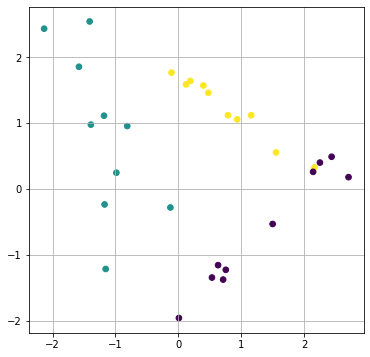

In [2]:
fig, ax = plt.subplots(figsize=(6, 6)); ax.grid(); ax.scatter(*X.T, c=y, s=32)
x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
XX = np.c_[np.ravel(xx), np.ravel(yy)]

In [3]:
W, eta = np.zeros((N + 1, 3, 2)), 0.3
for n in np.arange(N):
    an = W[n, :, :] @ X[n, :]
    mun = np.exp(an - logsumexp(an))
    mun[y[n]] =- 1.0
    W[n+1, :, :] = W[n, :, :] - eta * np.outer(mun, X[n, :])
    if n < 3: print(n+1, W[n+1, :, :])

1 [[-0.21636225 -0.03254466]
 [-0.21636225 -0.03254466]
 [ 0.64908675  0.09763397]]
2 [[-0.09512443 -0.06264664]
 [-0.51215749  0.04089796]
 [ 0.70240635  0.08439532]]
3 [[ 0.63559128  0.0834669 ]
 [-0.54351318  0.0346281 ]
 [ 0.0853767  -0.03898562]]


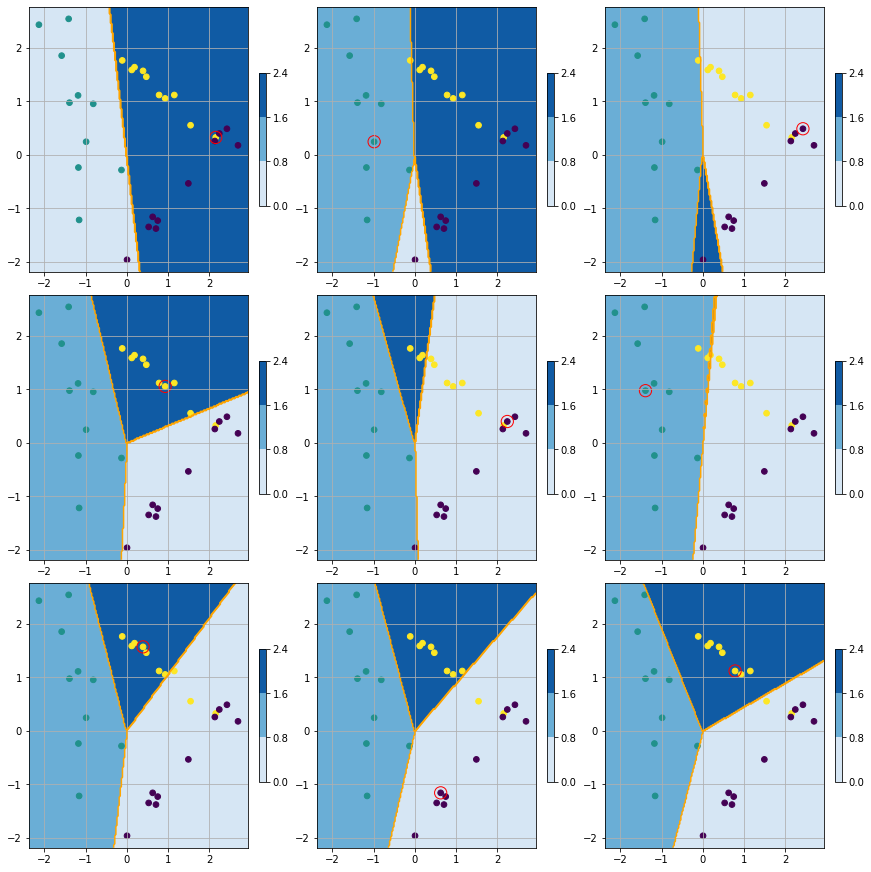

In [4]:
nrows = ncols = int(min(3, np.ceil(np.sqrt(N))));
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), constrained_layout=True)
for n in np.arange(min(N, nrows * ncols)):
    ax = axes.flat[n]; ax.axis('off'); ax = fig.add_subplot(nrows, ncols, n + 1); ax.grid()
    z = lambda x: np.argmax(W[n+1, :, :] @ x)
    zz = np.apply_along_axis(z, 1, XX)
    ax.contour(xx, yy, zz.reshape(xx.shape), 1, colors='orange', linestyles='solid')
    cp = ax.contourf(xx, yy, zz.reshape(xx.shape), 2, cmap='Blues')
    plt.colorbar(cp, ax=ax, shrink=0.5)
    ax.scatter(*X.T, c=y, s=32); ax.scatter(X[n, 0], X[n, 1], facecolors='none', edgecolors='red', s=150)